---

# Imports

---

In [7]:
from tensorflow import saved_model, concat
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import pickle
import matplotlib.pyplot as plt
import pyconll as pyc
import numpy as np
import pandas as pd

---

# Data cleaning and preprocessing

---

In [14]:
# load conllu data
train = pyc.load_from_file('./data/grc_perseus-ud-train.conllu')
test = pyc.load_from_file('./data/grc_perseus-ud-test.conllu')

In [256]:
# custom functions to use for mapping conllu data

def get_tuples(sentence):

    return [tuple([token.form, token.upos]) for token in sentence]

def get_words(sentence):
    return [token.form for token in sentence]

def get_texts(sentence):
    return sentence.text

def get_sents(sentence):
    return [sentence.text]

def get_arrays(data):
    return np.concatenate((data, np.zeros((max_word_len - data.shape[0], data.shape[1]),
                                            dtype=np.float32)))

In [261]:
# get tuples of words and tags

train_word_tag_tup = list(map(get_tuples, train))
test_word_tag_tup = list(map(get_tuples, test))

word_tag_tup = train_word_tag_tup.copy()
word_tag_tup.extend(test_word_tag_tup)
word_tag_tup = [item for sublist in word_tag_tup for item in sublist]

In [284]:
# create df from words and tags
df = pd.DataFrame(data = word_tag_tup, columns=['words', 'tags'])

# normalize words by making them lowercase 
df.words = df.words.str.lower()

# drop duplicates
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38549 entries, 0 to 180852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   words   38549 non-null  object
 1   tags    38549 non-null  object
dtypes: object(2)
memory usage: 903.5+ KB


In [328]:
# get all of the words
flat_words = df.words.values

# find maximum length of words in order to pad the matrices
max_word_len = len(max(flat_words, key=len))
max_word_len

In [289]:
# combine all texts into one in order to 
texts = ''.join(flat_words)

texts = texts.replace(' ', '')

In [331]:
# instatiate tokenizer and fit on texts to get character encoding for each word
tokenizer = Tokenizer(num_words=None, char_level=True)
tokenizer.fit_on_texts(texts)

In [329]:
# # WORKS!! DONT LOSE IT!!
# get word x 139 matrices from tokenizer
word_arrays = np.array([tk_words.texts_to_matrix(word) for word in flat_words])


In [330]:
# pad the matrices to 20 x 139 to keep them the same
arrays = np.array(list(map(get_arrays, word_arrays)))

In [294]:
# # used in flask app
# # rough-draft for how to handle user_input
# test = 'ἐρᾷ μὲν ἁγνὸς οὐρανὸς τρῶσαι χθόνα ἔρως δὲ γαῖαν λαμβάνει γάμου τυχεῖν'

# test = test.split()
# # test = re.split(r'(,.?·)', test)
# print(test)

# test_input = test

# test_input = np.array([word for word in test_input])

# test_output = np.array([tk_words.texts_to_matrix(word) for word in test_input])

# test_arrays = np.array(list(map(get_arrays, test_output)))

['ἐρᾷ', 'μὲν', 'ἁγνὸς', 'οὐρανὸς', 'τρῶσαι', 'χθόνα', 'ἔρως', 'δὲ', 'γαῖαν', 'λαμβάνει', 'γάμου', 'τυχεῖν']


---

# Getting X and y

---

In [327]:
# get all of the tags to pass to LabelBinarizer
tags = df.tags.values

In [332]:
# instantiate and fit LabelBinarizer on the tags to get binarized y labels
lb = LabelBinarizer()

lb.fit(tags)

LabelBinarizer()

In [333]:
# save labels to use for predictions
labels = lb.classes_

In [334]:
# define variables
X = arrays
y = df.tags.values

In [335]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [336]:
# transform y
y = lb.transform(tags)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

---

# Modeling

---

In [383]:
def define_model():
    # shared input layer
    inputs1 = Input(shape=(20,139))
    
    # first cnn
    cnn1 = Conv1D(filters=30, kernel_size=(2), activation='relu')(inputs1)
    cnn2 = BatchNormalization()(cnn1)
    cnn3 = MaxPooling1D(pool_size=(3))(cnn2)


    # second cnn
    cnn6 = Conv1D(filters=30, kernel_size=(3), activation='relu')(inputs1)
    cnn7 = BatchNormalization()(cnn6)
    cnn8 = MaxPooling1D(pool_size=(3))(cnn7)


    #thrid cnn
    cnn9 = Conv1D(filters=30, kernel_size=(4), activation='relu')(inputs1)
    cnn10 = BatchNormalization(trainable=True)(cnn9)
    cnn11 = MaxPooling1D(pool_size=(3))(cnn10)


    # merge all of the cnn models together
    cnn_total = concat(axis=1, values = [cnn3, cnn8, cnn11])


    flatten = Flatten()(cnn_total)
    dropout = Dropout(0.5)(flatten)
    # output layer
    outputs = Dense(14, activation='softmax')(dropout)
    

    model = Model(inputs=inputs1, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics=['accuracy'])
    

    return model

model = define_model()

callback = EarlyStopping(monitor='loss', patience=5)
hist = model.fit(x=X_train, y=y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=callback, batch_size=256)

---

# Metrics

---

In [386]:
# Evaluate model on test data.
score = model.evaluate(arrays, y, verbose=1)

cnn_labels = model.metrics_names

1205/1205 [==============================] - 4s 3ms/step - loss: 0.4155 - accuracy: 0.8479


In [396]:
# get predictions
preds = model.predict(arrays)

# turn them back into tags
y_preds = [labels[np.argmax(pred)] for pred in preds]
y_true = [labels[np.argmax(pred)] for pred in y]

In [397]:
y_preds[:5]

['VERB', 'PART', 'ADJ', 'NOUN', 'VERB']

In [399]:
y_true[:5]

['VERB', 'ADV', 'ADJ', 'NOUN', 'VERB']

In [401]:
# print classification report
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

         ADJ       0.80      0.67      0.73      7351
         ADP       0.68      0.48      0.56       224
         ADV       0.81      0.53      0.64      1083
       CCONJ       0.48      0.43      0.46        53
         DET       0.52      0.26      0.35        50
        INTJ       0.61      0.37      0.46        30
        NOUN       0.78      0.86      0.82     11579
         NUM       0.75      0.21      0.33        42
        PART       0.50      0.43      0.46        96
        PRON       0.61      0.69      0.65       594
       PUNCT       1.00      0.50      0.67        10
       SCONJ       0.67      0.34      0.45        87
        VERB       0.93      0.95      0.94     17326
           X       0.55      0.25      0.34        24

    accuracy                           0.85     38549
   macro avg       0.69      0.50      0.56     38549
weighted avg       0.85      0.85      0.84     38549



In [405]:
len(hist.history['loss'])

66

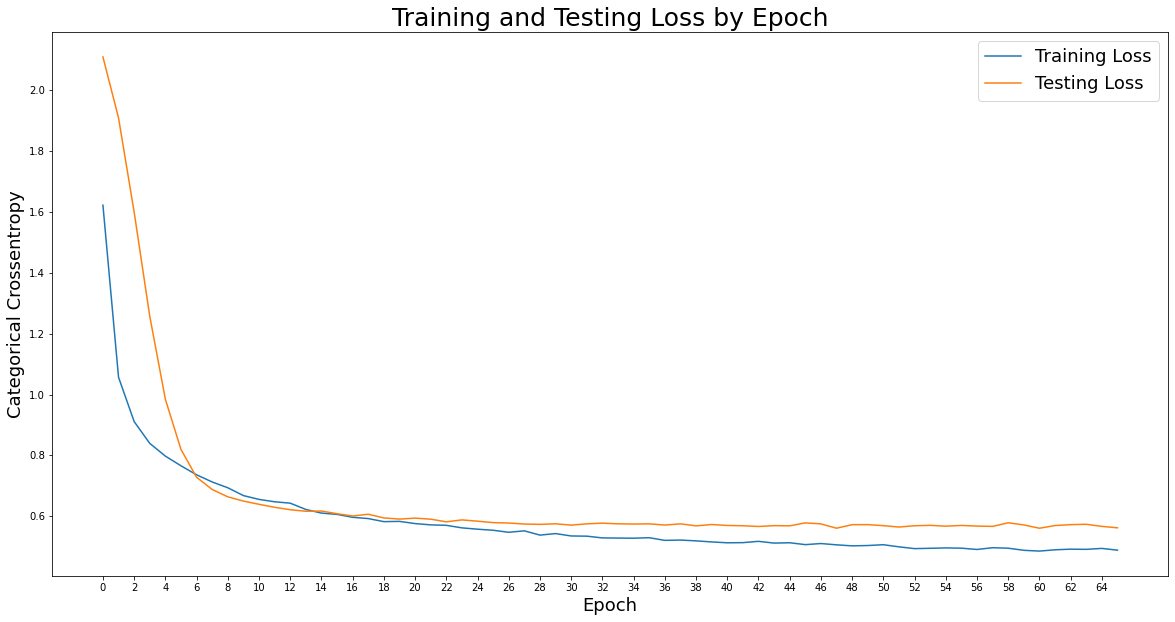

In [415]:
# Check out our train loss and test loss over epochs.
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']


# Set figure size.
plt.figure(figsize=(20, 10))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')


# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(66, step=2), np.arange(66, step=2))

plt.legend(fontsize = 18);

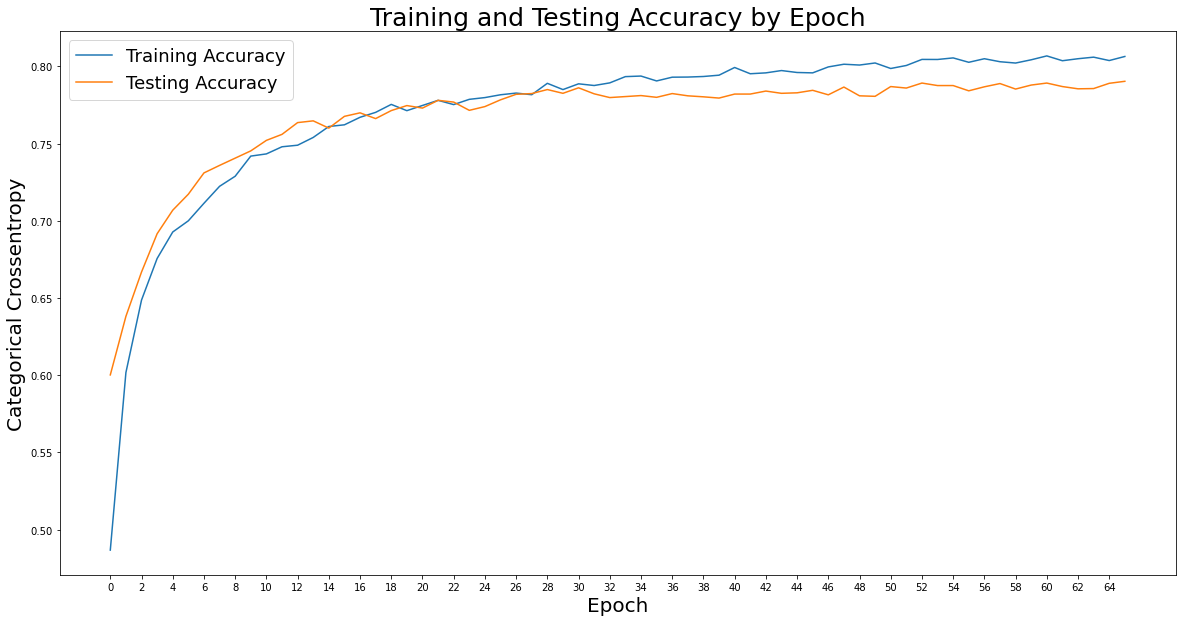

In [417]:
# Check out our train loss and test loss over epochs.
train_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(20, 10))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')


# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Categorical Crossentropy', fontsize = 20)
plt.xticks(np.arange(66, step=2), np.arange(66, step=2))

plt.legend(fontsize = 18);

---

# Saving models

---

In [418]:
# saved_model.save(model, './models/')

INFO:tensorflow:Assets written to: ./models/assets


In [2]:
# model = load_model('./models')

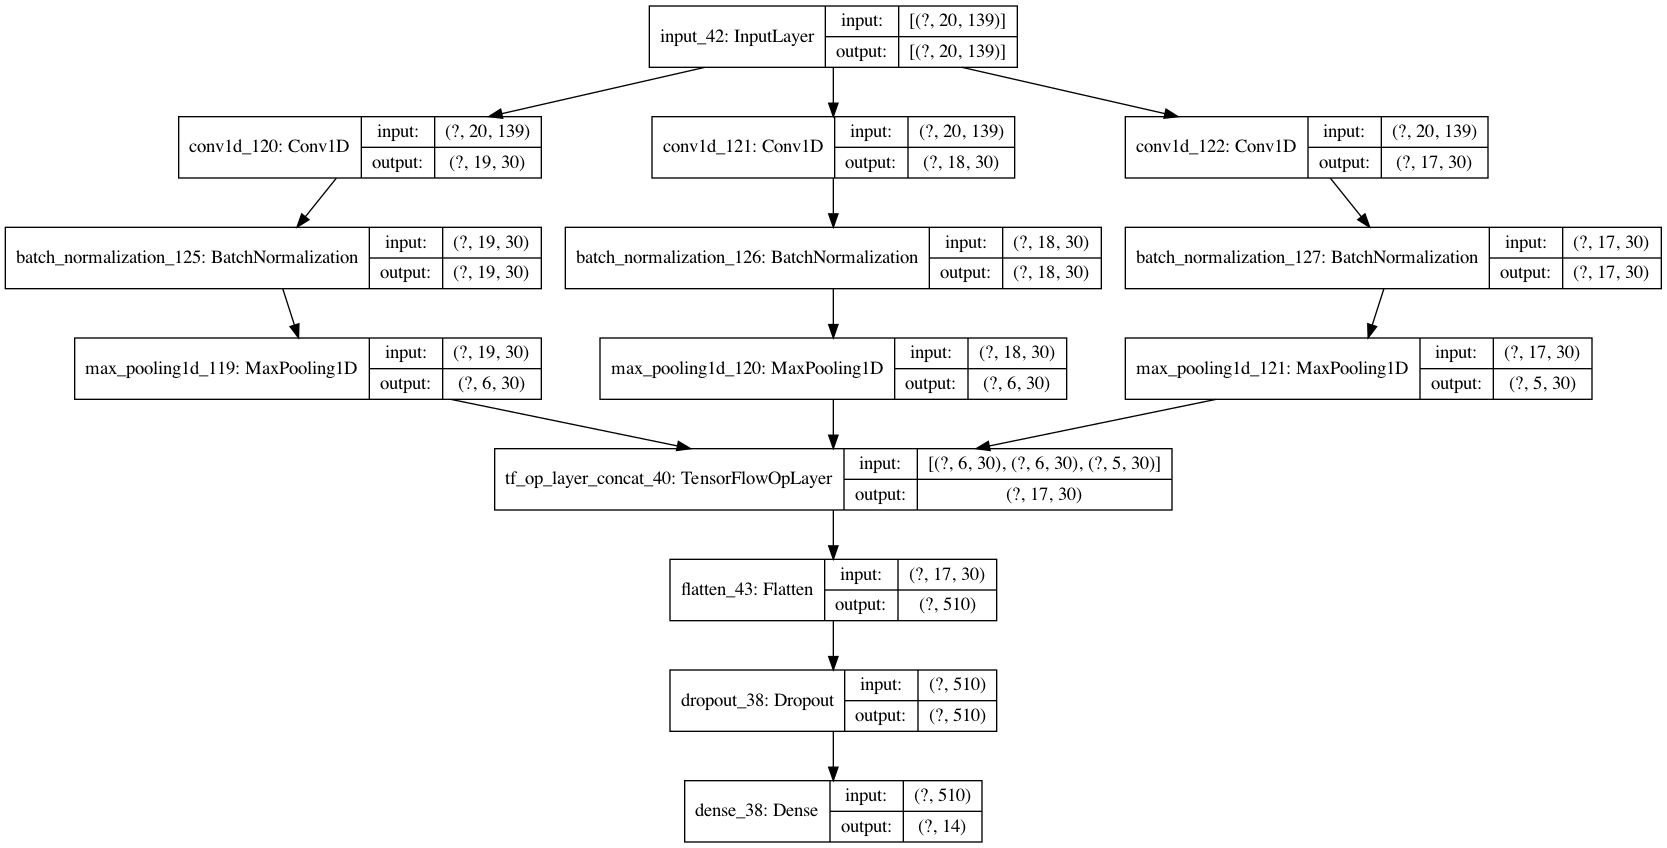

In [11]:
plot_model(model, show_shapes=True, expand_nested=True)

In [419]:
# with open('./tagger/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tk_words, handle ,protocol=pickle.HIGHEST_PROTOCOL)